# Modulation Classification

Developing AutoML Model for AWGN Channel for Modulation Classification. SNR Ratio's(in dB) of Channel are $[5,10,15,20,25,30]$.

**Data Generation:**
Data is generated using MatLab's Communication Toolbox for Modulation Schemes QPSK, 16-QAM, 64-QAM for SNR Ratio's (in dB) $[5,10,15,20,25,30]$ when signal is transmitted through Channels AWGN and Rayleigh Channels.

**Modulation Classification:**
We will use AutoML to creae a classifer that predicts Modulation Scheme depending on In-Phase and Quadrature-Phase Components at the Receiver's End.

## Imports

### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os

# AutoML Libraries
!pip3 install autokeras
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf

### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/AutoML

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Modulation-Classification/AutoML


## Processsing Data

Importing Data for all SNR Ratio's

In [3]:
def ImportData(Path):
    ModulationSchemes = os.listdir(Path)

    Dataset = {}
    for scheme in ModulationSchemes:
        DataPath = Path + "/" + scheme
        files = os.listdir(DataPath)
        DataofScheme = {}
        for f in files:
            Data = scipy.io.loadmat(DataPath + "/" + f)
            snr = Data['snr'][0][0]
            rx = Data['rx']
            InPhase, QuadPhase = rx.real, rx.imag
            DataofScheme[snr] = np.append(InPhase, QuadPhase, axis=1)
        Dataset[scheme] = DataofScheme

    return Dataset

## Train and Validation Datasets

**Training:**
- Received Signal with SNR Ratio $30$dB is used for Training for both Channels and all Modulation Schemes.

**Validation:**
- AutoML is validated on Received Signals with SNR Ratio's (in dB) $[5,10,15,20,25]$

In [4]:
def GenerateDatasets(Channel):
    Path = "../Data/" + Channel
    Data = ImportData(Path)
    
    Dataset = {}
    Dataset['Classes'] = list(Data.keys())
    OneHotClasses = np.eye(len(Dataset['Classes']))

    Classes = {}
    for i in range(len(Dataset['Classes'])):
        Classes[Dataset['Classes'][i]] = OneHotClasses[i]

    Valid_SNRs = [5,10,15,20,25]

    if Channel == "AWGN":
        X_Train, y_Train = np.empty((0,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}

        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,2))
            y_Valid[snr] = np.empty((0,3))

        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)
    else:
        X_Train, y_Train = np.empty((0,100,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}
        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,100,2))
            y_Valid[snr] = np.empty((0,3))

        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    return X_Train, y_Train, X_Valid, y_Valid

## Evaluating Data

In [12]:
def EvaluateData(Model, X_Train, y_Train, X_Valid, y_Valid):
    Valid_SNR = np.array([5,10,15,20,25,30])
    Accuracy = []

    print ("Evaluating Model")
    for snr in Valid_SNR:
        if snr == 30:
            Loss, Acc = Model.evaluate(X_Train, y_Train)
        else:
            Loss, Acc = Model.evaluate(X_Valid[snr], y_Valid[snr])
        print ("SNR:", snr, "Accuracy:", Acc)
        Accuracy.append(Acc)

    Accuracy = np.array(Accuracy)

    plt.figure(figsize=(10,10))
    plt.plot(Valid_SNR,Accuracy, color='blue')
    plt.scatter(Valid_SNR,Accuracy, color='red')
    plt.title("Accuracy vs SNR")
    plt.xlabel("SNR")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.savefig("Images/AWGN_Accuracy.jpg")
    plt.show()

## AutoML Model for AWGN Channel

FOr AWGN Channel, input dimenstions is $(2,)$

AWGN Data

In [6]:
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets('AWGN')

Creating a Classifier

In [7]:
AWGNClassifier = ak.StructuredDataClassifier(
    overwrite=True,
    max_trials=10,
    loss='categorical_crossentropy',
    num_classes=3)

AWGNClassifier.fit(X_Train, y_Train, epochs=25, batch_size=64, validation_split=0.2)

Trial 10 Complete [00h 00m 34s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 05m 05s
INFO:tensorflow:Oracle triggered exit
Epoch 1/25
469/469 [==============================] - 2s 2ms/step - loss: 0.6110 - accuracy: 0.8100
Epoch 2/25
469/469 [==============================] - 1s 2ms/step - loss: 1.3709 - accuracy: 0.6267
Epoch 3/25
469/469 [==============================] - 1s 2ms/step - loss: 0.8197 - accuracy: 0.6626
Epoch 4/25
469/469 [==============================] - 1s 2ms/step - loss: 0.8962 - accuracy: 0.6688
Epoch 5/25
469/469 [==============================] - 1s 2ms/step - loss: 0.7979 - accuracy: 0.6614
Epoch 6/25
469/469 [==============================] - 1s 2ms/step - loss: 0.8207 - accuracy: 0.6397
Epoch 7/25
469/469 [==============================] - 1s 2ms/step - loss: 0.8331 - accuracy: 0.6266
Epoch 8/25
469/469 [==============================] - 1s 2ms/step - loss: 0.8149 - accuracy: 0.6390
Epoch 9/25
469/469 [=============================

Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 2)                 0         
_________________________________________________________________
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

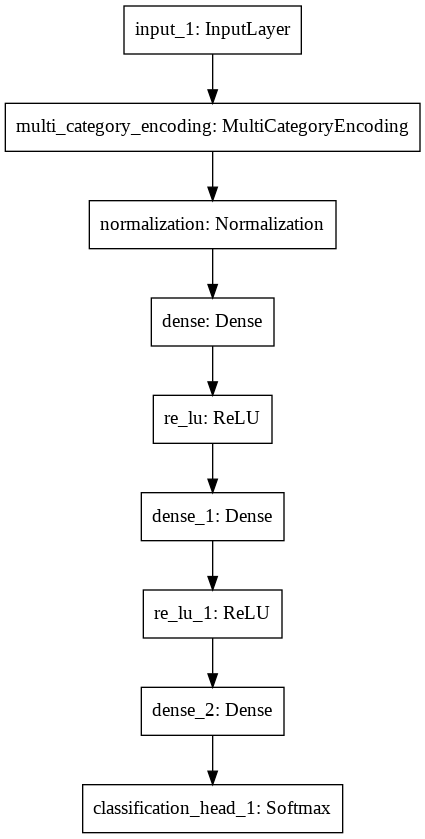

In [19]:
Model = AWGNClassifier.export_model()
Model.summary()
tf.keras.utils.plot_model(Model, to_file='Images/Model.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating Model

#### Training the Model

In [20]:
Model.fit(X_Train, y_Train, epochs=60, batch_size=64, validation_split=0.2)

Epoch 1/60
375/375 [==============================] - 1s 3ms/step - loss: 0.3441 - accuracy: 0.8758 - val_loss: 0.0342 - val_accuracy: 1.0000
Epoch 2/60
375/375 [==============================] - 1s 2ms/step - loss: 0.2916 - accuracy: 0.8957 - val_loss: 0.0232 - val_accuracy: 1.0000
Epoch 3/60
375/375 [==============================] - 1s 2ms/step - loss: 0.2777 - accuracy: 0.8957 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 4/60
375/375 [==============================] - 1s 2ms/step - loss: 0.2705 - accuracy: 0.8957 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 5/60
375/375 [==============================] - 1s 2ms/step - loss: 0.2666 - accuracy: 0.8957 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 6/60
375/375 [==============================] - 1s 2ms/step - loss: 0.2645 - accuracy: 0.8957 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/60
375/375 [==============================] - 1s 2ms/step - loss: 0.2638 - accuracy: 0.8957 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 

#### Evaluate the Model

Evaluating Model
938/938 [==============================] - 2s 2ms/step - loss: 1.8548 - accuracy: 0.7651
SNR: 5 Accuracy: 0.7650666832923889
938/938 [==============================] - 2s 2ms/step - loss: 0.8700 - accuracy: 0.8311
SNR: 10 Accuracy: 0.8311333060264587
938/938 [==============================] - 2s 2ms/step - loss: 0.3324 - accuracy: 0.8902
SNR: 15 Accuracy: 0.8901666402816772
938/938 [==============================] - 2s 2ms/step - loss: 0.2139 - accuracy: 0.9150
SNR: 20 Accuracy: 0.9150333404541016
938/938 [==============================] - 2s 2ms/step - loss: 0.2087 - accuracy: 0.9165
SNR: 25 Accuracy: 0.916533350944519
938/938 [==============================] - 2s 2ms/step - loss: 0.2086 - accuracy: 0.9165
SNR: 30 Accuracy: 0.916533350944519


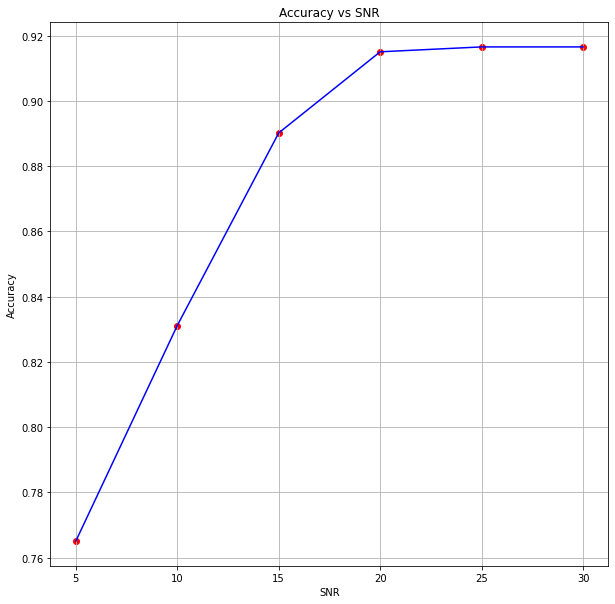

In [21]:
EvaluateData(Model, X_Train, y_Train, X_Valid, y_Valid)

Save Model

In [22]:
Model.save("Model/AWGN.h5")